In [1]:
import pandas as pd
import pvlib
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('resultados.csv') 
data = data.drop(columns=['Unnamed: 0','Datetime_local'])
data['Datetime'] = pd.to_datetime(data['Datetime'])  
data['datetime_utc'] = data['Datetime'].dt.tz_localize('UTC')
data['datetime_local'] = data['datetime_utc'].dt.tz_convert('America/Sao_Paulo')
display(data)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI,datetime_utc,datetime_local
0,15.0,15.000000,2019-10-20 00:00:00,0.000000,0,0,0,2019-10-20 00:00:00+00:00,2019-10-19 21:00:00-03:00
1,15.0,15.000000,2019-10-20 00:30:00,0.000000,0,0,0,2019-10-20 00:30:00+00:00,2019-10-19 21:30:00-03:00
2,15.0,15.000000,2019-10-20 01:00:00,0.000000,0,0,0,2019-10-20 01:00:00+00:00,2019-10-19 22:00:00-03:00
3,15.0,15.000000,2019-10-20 01:30:00,0.000000,0,0,0,2019-10-20 01:30:00+00:00,2019-10-19 22:30:00-03:00
4,15.0,15.000000,2019-10-20 02:00:00,0.000000,0,0,0,2019-10-20 02:00:00+00:00,2019-10-19 23:00:00-03:00
...,...,...,...,...,...,...,...,...,...
3499,60.0,56.291179,2019-12-31 21:30:00,9.925587,0,0,0,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00
3500,15.0,15.000000,2019-12-31 22:00:00,0.000000,0,0,0,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00
3501,15.0,15.000000,2019-12-31 22:30:00,0.000000,0,0,0,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00
3502,15.0,15.000000,2019-12-31 23:00:00,0.000000,0,0,0,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00


In [3]:
latitude = -23.55052
longitude = -46.633308
altitude = 590
albedo = 0.08

In [4]:
def calculate_irradiance(row, angle, latitude, longitude):
    solar_position = pvlib.solarposition.get_solarposition(row['Datetime'], latitude, longitude)
    dni_extra = pvlib.irradiance.get_extra_radiation(row['Datetime'])

    poa_components = pvlib.irradiance.get_total_irradiance(
        surface_tilt=angle,
        surface_azimuth=90,
        dni=row['DNI'],
        ghi=row['GHI'],
        dhi=row['DHI'],
        solar_zenith=solar_position['zenith'],
        solar_azimuth=solar_position['azimuth'],
        dni_extra=dni_extra,
        airmass=pvlib.atmosphere.get_relative_airmass(solar_position['zenith']),
        albedo=albedo
    )
    total_irrad = poa_components['poa_global'].iloc[0] # iloc pega o valor numerico da série
    return total_irrad

In [5]:
irradiancias_IA = []  # Se for inicializada dentro do loop ela é zerada a cada iteração
irradiancias_SPA = []
for i, row in data.iterrows():
  angle = row['Predito'] # Vai pegar somente o angulo especifico de cada linha da iteração
  angle2 = row['Theta']
  irradiance = calculate_irradiance(row, angle, latitude, longitude)
  irradiance2 = calculate_irradiance(row, angle2, latitude, longitude)
  irradiancias_IA.append(irradiance)
  irradiancias_SPA.append(irradiance2)

data['irradiancias IA'] = irradiancias_IA
data['irradiancias SPA'] = irradiancias_SPA
 

In [6]:
display(data)

,Real,Predito,Datetime,Theta,GHI,DNI,DHI,datetime_utc,datetime_local,irradiancias IA,irradiancias SPA
0,15.0,15.000000,2019-10-20 00:00:00,0.000000,0,0,0,2019-10-20 00:00:00+00:00,2019-10-19 21:00:00-03:00,0.0,0.0
1,15.0,15.000000,2019-10-20 00:30:00,0.000000,0,0,0,2019-10-20 00:30:00+00:00,2019-10-19 21:30:00-03:00,0.0,0.0
2,15.0,15.000000,2019-10-20 01:00:00,0.000000,0,0,0,2019-10-20 01:00:00+00:00,2019-10-19 22:00:00-03:00,0.0,0.0
3,15.0,15.000000,2019-10-20 01:30:00,0.000000,0,0,0,2019-10-20 01:30:00+00:00,2019-10-19 22:30:00-03:00,0.0,0.0
4,15.0,15.000000,2019-10-20 02:00:00,0.000000,0,0,0,2019-10-20 02:00:00+00:00,2019-10-19 23:00:00-03:00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3499,60.0,56.291179,2019-12-31 21:30:00,9.925587,0,0,0,2019-12-31 21:30:00+00:00,2019-12-31 18:30:00-03:00,0.0,0.0
3500,15.0,15.000000,2019-12-31 22:00:00,0.000000,0,0,0,2019-12-31 22:00:00+00:00,2019-12-31 19:00:00-03:00,0.0,0.0
3501,15.0,15.000000,2019-12-31 22:30:00,0.000000,0,0,0,2019-12-31 22:30:00+00:00,2019-12-31 19:30:00-03:00,0.0,0.0
3502,15.0,15.000000,2019-12-31 23:00:00,0.000000,0,0,0,2019-12-31 23:00:00+00:00,2019-12-31 20:00:00-03:00,0.0,0.0


In [6]:
data.to_csv('irradiancias.csv')

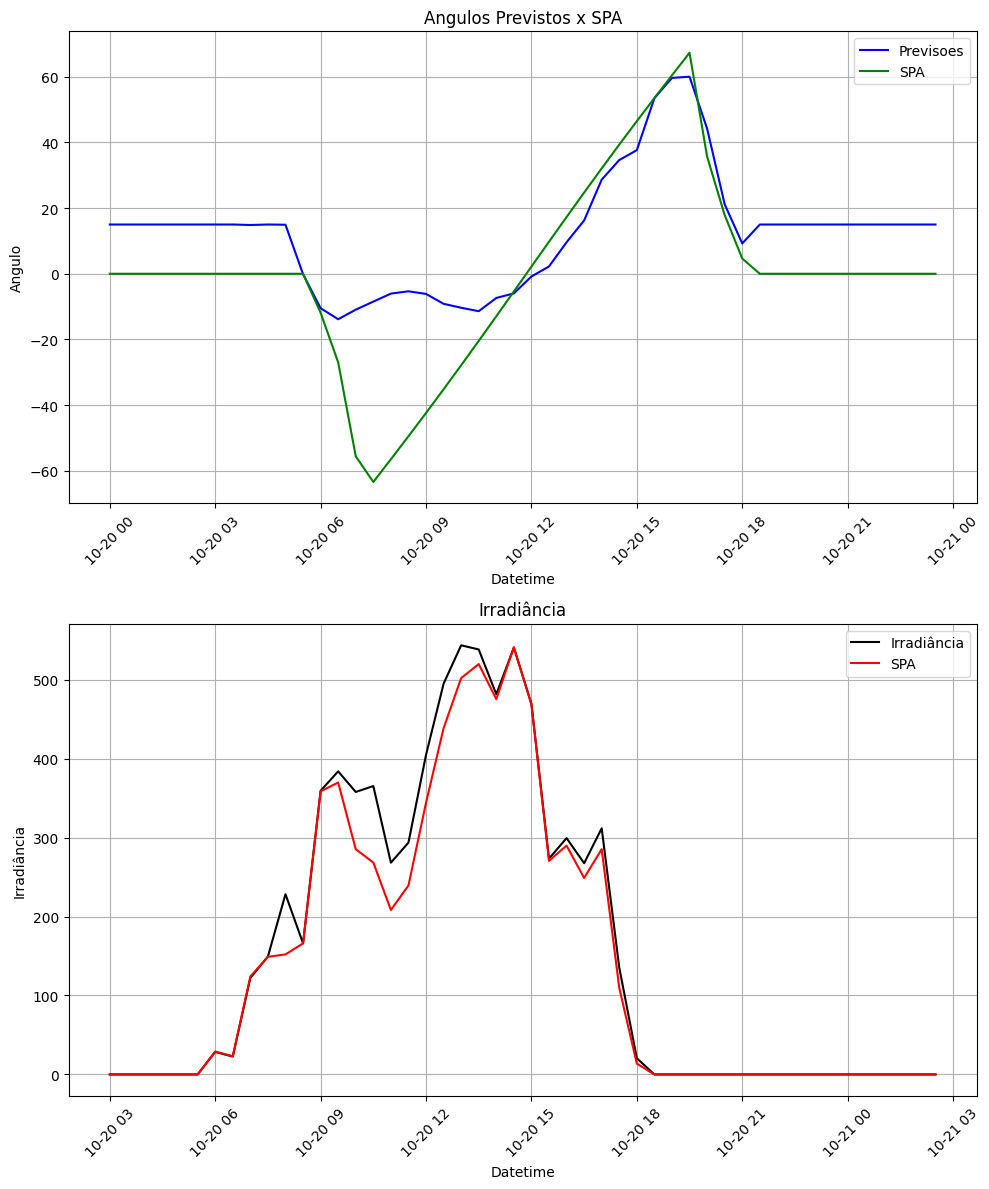

In [9]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 12)) 

dates_desejados = data['datetime_local'][6:54] 
dates = data['Datetime'][6:54] 
angulos_previstos = data['Predito'][6:54] 
angulos_SPA = data['Theta'][6:54]
irradiancia_ia = data['irradiancias IA'][6:54]    
irradiancia_spa = data['irradiancias SPA'][6:54]  

# Primeiro subplot para Irradiância IA
plt.subplot(2, 1, 1)  # (número de linhas, número de colunas, índice do plot)
plt.plot(dates_desejados, angulos_previstos, label='Previsoes', color='blue')
plt.plot(dates_desejados, angulos_SPA , label='SPA', color='green')
plt.xlabel('Datetime')
plt.ylabel('Angulo')
plt.title('Angulos Previstos x SPA')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Segundo subplot para Irradiância SPA
plt.subplot(2, 1, 2)
plt.plot(dates, irradiancia_ia, label='Irradiância', color='black')
plt.plot(dates, irradiancia_spa , label='SPA', color='red')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Exibir os gráficos
plt.show()

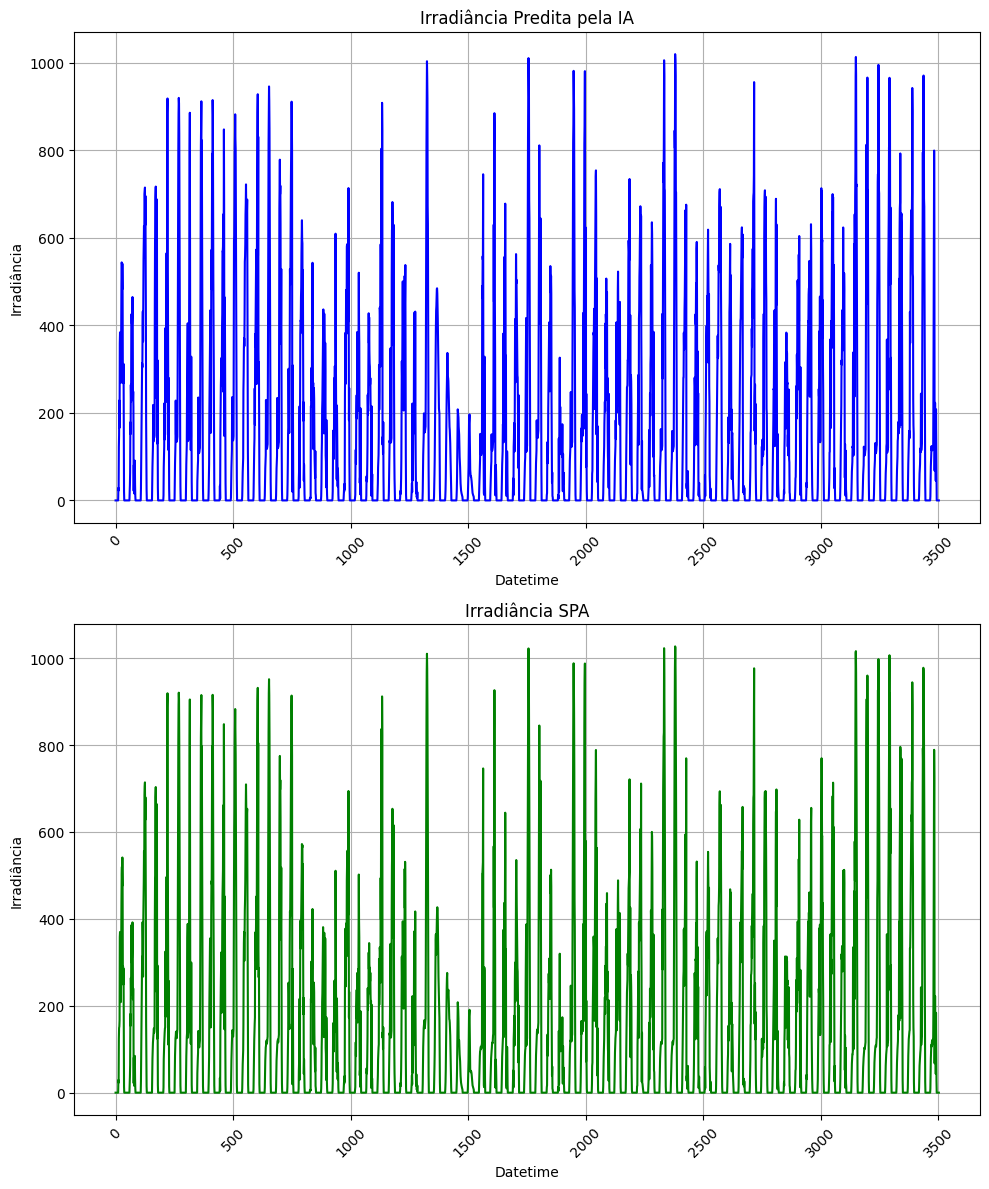

In [7]:
import matplotlib.pyplot as plt

# Criar uma figura com dois subplots (um para cada curva)
plt.figure(figsize=(10, 12))  # Tamanho da figura

# Primeiro subplot para Irradiância IA
plt.subplot(2, 1, 1)  # (número de linhas, número de colunas, índice do plot)
plt.plot(data.index, data['irradiancias IA'], label='Irradiância IA', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância Predita pela IA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Segundo subplot para Irradiância SPA
plt.subplot(2, 1, 2)
plt.plot(data.index, data['irradiancias SPA'], label='Irradiância SPA', color='green')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância SPA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Exibir os gráficos
plt.show()


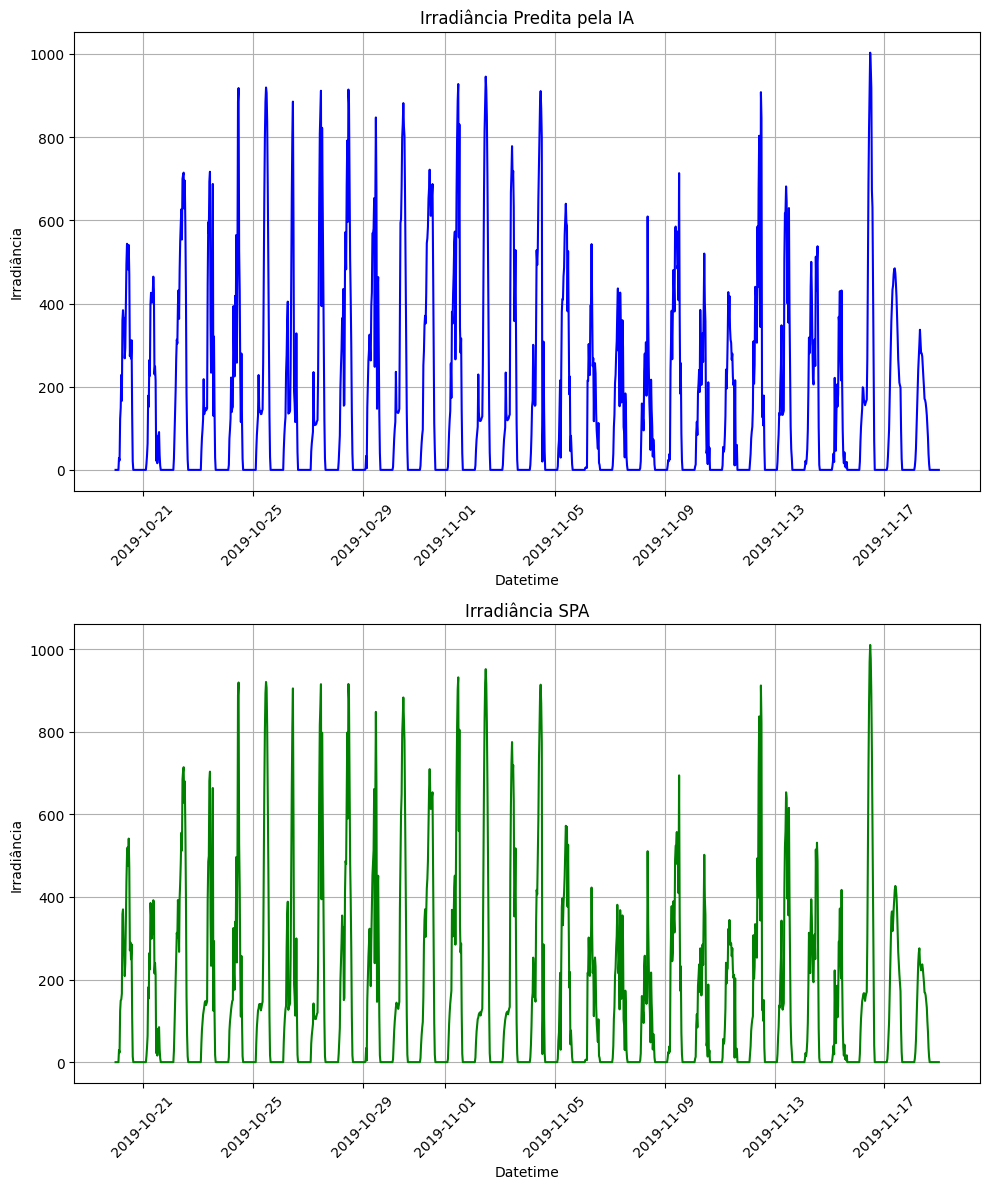

In [8]:
import matplotlib.pyplot as plt

# Criar uma figura com dois subplots (um para cada curva)
plt.figure(figsize=(10, 12))  # Tamanho da figura

dates_desejados = data['datetime_local'][6:1446] 
irradiancia_ia = data['irradiancias IA'][6:1446]  
irradiancia_spa = data['irradiancias SPA'][6:1446]

# Primeiro subplot para Irradiância IA
plt.subplot(2, 1, 1)  # (número de linhas, número de colunas, índice do plot)
plt.plot(dates_desejados, irradiancia_ia, label='Irradiância IA', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância Predita pela IA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Segundo subplot para Irradiância SPA
plt.subplot(2, 1, 2)
plt.plot(dates_desejados, irradiancia_spa, label='Irradiância SPA', color='green')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância SPA')
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Exibir os gráficos
plt.show()

In [9]:
from scipy.integrate import trapz
# Agrupar os dados por dia
data['Date'] = data['datetime_local'].dt.date
daily_groups = data.groupby('Date') # Conjunto de grupos com dados de cada dia

energia_diaria = {}

# Iterar sobre cada grupo diário e calcular a energia gerada
for date, group in daily_groups:
    # Ordenar os dados por 'Datetime' para garantir a sequência correta de integração
    group = group.sort_values('datetime_local')
    
    time_interval_hours = 0.5  # Intervalo de 30 minutos = 0.5 horas (base do trapézio)
    irradiancia_IA = group['irradiancias IA'].values
    energia_IA = trapz(irradiancia_IA, dx=time_interval_hours)  
    
    irradiancia_SPA = group['irradiancias SPA'].values
    energia_SPA = trapz(irradiancia_SPA, dx=time_interval_hours) 

    energia_diaria[date] = {
        'energia_IA': energia_IA,  
        'energia_SPA': energia_SPA 
    }

for date, energia in energia_diaria.items():
    print(f"Data: {date}, Energia IA: {energia['energia_IA']}, Energia SPA: {energia['energia_SPA']}")


Data: 2019-10-19, Energia IA: 0.0, Energia SPA: 0.0
Data: 2019-10-20, Energia IA: 3763.0624926655196, Energia SPA: 3440.2389971583766
Data: 2019-10-21, Energia IA: 2483.0940919589557, Energia SPA: 2224.986426228703
Data: 2019-10-22, Energia IA: 5030.20375720853, Energia SPA: 4657.997441519168
Data: 2019-10-23, Energia IA: 3619.5696457636604, Energia SPA: 3381.010026524722
Data: 2019-10-24, Energia IA: 3727.4062326656363, Energia SPA: 3431.666179432168
Data: 2019-10-25, Energia IA: 4476.509070354447, Energia SPA: 4366.0001192060045
Data: 2019-10-26, Energia IA: 3477.279956205726, Energia SPA: 3399.945911359402
Data: 2019-10-27, Energia IA: 3971.925929786314, Energia SPA: 3889.852059673111
Data: 2019-10-28, Energia IA: 4895.118430385162, Energia SPA: 4671.335049587974
Data: 2019-10-29, Energia IA: 4464.147908982797, Energia SPA: 4146.780963037816
Data: 2019-10-30, Energia IA: 4715.147028835801, Energia SPA: 4520.274421617753
Data: 2019-10-31, Energia IA: 5147.229145303359, Energia SPA: 4

C:\Users\Marina\AppData\Local\Temp\ipykernel_3912\121730437.py:15: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  energia_IA = trapz(irradiancia_IA, dx=time_interval_hours)
C:\Users\Marina\AppData\Local\Temp\ipykernel_3912\121730437.py:18: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  energia_SPA = trapz(irradiancia_SPA, dx=time_interval_hours)


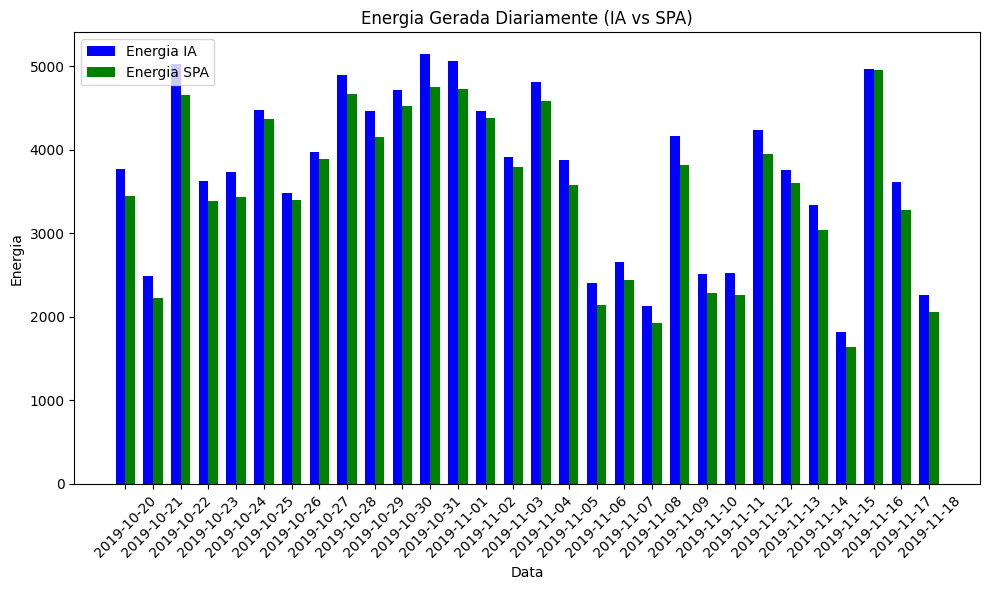

In [10]:
datas = list(energia_diaria.keys())[1:31]
energia_IA = [energia['energia_IA'] for energia in energia_diaria.values()][1:31]
energia_SPA = [energia['energia_SPA'] for energia in energia_diaria.values()][1:31]

largura_barras = 0.35
indices = np.arange(len(datas))


plt.figure(figsize=(10, 6))
plt.bar(indices, energia_IA, width=largura_barras, label='Energia IA', color='blue')
plt.bar(indices + largura_barras, energia_SPA, width=largura_barras, label='Energia SPA', color='green')
plt.xlabel('Data')
plt.ylabel('Energia')
plt.title('Energia Gerada Diariamente (IA vs SPA)')
plt.xticks(indices + largura_barras / 2, datas, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


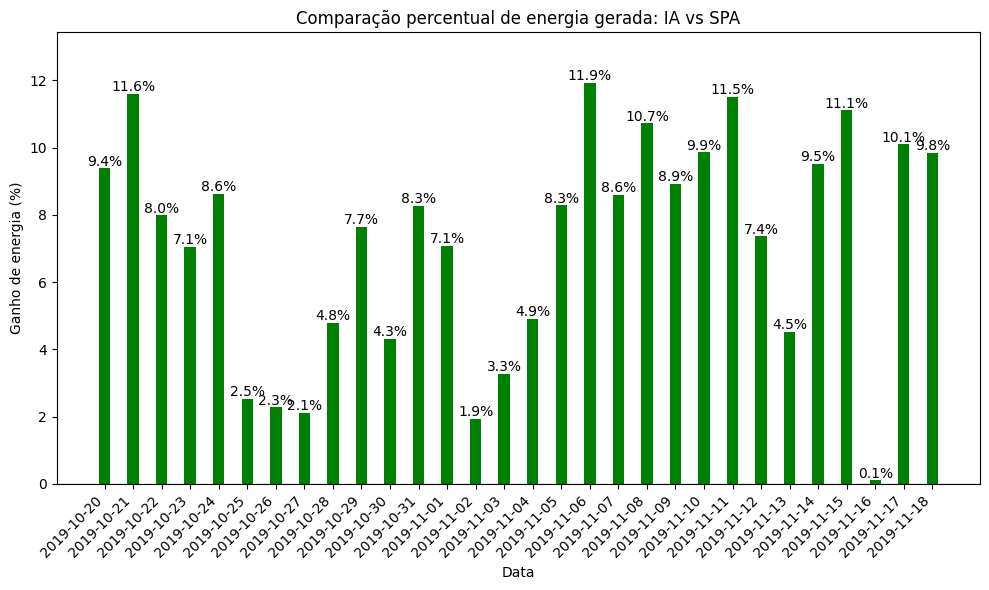

In [11]:
datas = list(energia_diaria.keys())[1:31]
energia_IA = np.array([energia['energia_IA'] for energia in energia_diaria.values()])[1:31]
energia_SPA = np.array([energia['energia_SPA'] for energia in energia_diaria.values()])[1:31]

diff_energia = energia_IA - energia_SPA
percentual_diferenca = (diff_energia / energia_SPA) * 100 # SPA como base

indices = np.arange(len(datas))
largura_barras = 0.4


plt.figure(figsize=(10, 6))
cores = ['green' if d > 0 else 'red' for d in percentual_diferenca]
plt.bar(indices, percentual_diferenca, color=cores, width=largura_barras)
plt.xlabel('Data')
plt.ylabel('Ganho de energia (%)')
plt.title('Comparação percentual de energia gerada: IA vs SPA')
plt.xticks(indices, datas, rotation=45,ha='right')
plt.axhline(0, color='black',linewidth=0.8)
for i, (perc, diff) in enumerate(zip(percentual_diferenca, diff_energia)):
    if diff > 0:
        plt.text(i, perc + 0.08, f'{perc:.1f}%', ha='center', color='black')  
    else:
        plt.text(i, perc - 0.07 * abs(diff), f'{perc:.1f}%', ha='center', color='black')    

plt.ylim(bottom= 0, top=max(percentual_diferenca) + 1.5)
plt.tight_layout()
plt.show()


In [28]:
indicekt = pd.read_csv('classificacao_diaria_kt_2019.csv')
indicekt['date'] = pd.to_datetime(indicekt['date'])
indicekt = indicekt[indicekt['date'] >= pd.to_datetime('2019-10-19')]
indicekt = indicekt.reset_index()
indicekt = indicekt.drop(columns=['index'])
display(indicekt)
df_energia = pd.DataFrame.from_dict(energia_diaria, orient='index')
df_energia.index.name = 'Data'
df_energia= df_energia.reset_index()
df_energia['classificacao'] = indicekt['classification']
display(df_energia)

,date,Kt_mean,classification
0,2019-10-19,0.806342,Ensolarado
1,2019-10-20,0.853691,Ensolarado
2,2019-10-21,0.391521,Parcialmente Nublado
3,2019-10-22,0.600913,Parcialmente Ensolarado
4,2019-10-23,0.841069,Ensolarado
...,...,...,...
69,2019-12-27,0.823162,Ensolarado
70,2019-12-28,0.824643,Ensolarado
71,2019-12-29,0.846618,Ensolarado
72,2019-12-30,0.830571,Ensolarado


,Data,energia_IA,energia_SPA,classificacao
0,2019-10-19,0.000000,0.000000,Ensolarado
1,2019-10-20,3765.262378,3440.238997,Ensolarado
2,2019-10-21,2484.001096,2224.986426,Parcialmente Nublado
3,2019-10-22,5035.851859,4657.997442,Parcialmente Ensolarado
4,2019-10-23,3621.394244,3381.010027,Ensolarado
...,...,...,...,...
69,2019-12-27,4626.423409,4579.703797,Ensolarado
70,2019-12-28,4512.827400,4336.793930,Ensolarado
71,2019-12-29,5065.812049,4807.485270,Ensolarado
72,2019-12-30,4765.966529,4710.862257,Ensolarado


In [41]:
import numpy as np
import cv2
import plotly.graph_objects as go
import base64

# Supondo que energia_diaria seja um dicionário com os dados já carregados
datas = df_energia['Data'][1:31].tolist()  # Converter para lista
energia_IA = df_energia['energia_IA'][1:31].tolist()  # Converter para lista
energia_SPA = df_energia['energia_SPA'][1:31].tolist()  # Converter para lista

# Cálculo da diferença e percentual
diff_energia = np.array(energia_IA) - np.array(energia_SPA)
percentual_diferenca = (diff_energia / np.array(energia_SPA)) * 100  # SPA como base

# Seleciona as imagens com base na coluna de classificação
imagens_clima = []
for classificacao in df_energia['classificacao'][1:31]:  # Certifique-se de acessar o mesmo intervalo
    if classificacao == 'Ensolarado':
        imagens_clima.append('E.png')
    elif classificacao == 'Nublado':
        imagens_clima.append('N.png')
    elif classificacao == 'Parcialmente Nublado':
        imagens_clima.append('PN.png')
    elif classificacao == 'Parcialmente Ensolarado':
        imagens_clima.append('PE.png')
    else:
        imagens_clima.append('default.png')  # Imagem padrão caso não corresponda a nenhuma classificação

# Carregando as imagens usando OpenCV e convertendo para base64
imagens_clima_b64 = []
for img_path in imagens_clima:
    img = cv2.imread(img_path)
    if img is not None:  # Verifica se a imagem foi carregada corretamente
        img_resized = cv2.resize(img, (40, 40))  # Redimensiona a imagem para 40x40 pixels
        _, img_encoded = cv2.imencode('.png', img_resized)  # Codifica a imagem em PNG
        img_b64 = base64.b64encode(img_encoded).decode('utf-8')  # Converte para base64
        imagens_clima_b64.append(f'data:image/png;base64,{img_b64}')  # Adiciona o prefixo base64
    else:
        imagens_clima_b64.append(None)  # Adiciona None se a imagem não foi carregada

# Criação do gráfico
fig = go.Figure()

# Adiciona as barras ao gráfico
cores = ['green' if d > 0 else 'red' for d in percentual_diferenca]
fig.add_trace(go.Bar(
    x=datas,
    y=percentual_diferenca,
    marker_color=cores,
    width=0.4,
    name='Ganho de energia (%)'
))

# Adiciona valores percentuais diretamente nas barras
for i in range(len(percentual_diferenca)):
    perc = percentual_diferenca[i]
    diff = diff_energia[i]
    
    if diff > 0:
        fig.add_annotation(
            x=datas[i],
            y=perc + 0.08,
            text=f'{perc:.1f}%',
            showarrow=False,
            font=dict(color='black')
        )
    else:
        fig.add_annotation(
            x=datas[i],
            y=perc - 0.07 * abs(diff),
            text=f'{perc:.1f}%',
            showarrow=False,
            font=dict(color='black')
        )

# Adiciona imagens acima das barras
for i, img_b64 in enumerate(imagens_clima_b64):
    if img_b64 is not None:  # Verifica se a imagem foi carregada corretamente
        fig.add_layout_image(
            dict(
                source=img_b64,
                x=datas[i],
                y=percentual_diferenca[i] + 2,  # Ajuste a posição vertical
                xref="x",
                yref="y",
                sizex=0.3,
                sizey=0.3,
                xanchor="center",
                yanchor="bottom",
            )
        )

# Atualizações do layout
fig.update_layout(
    title='Comparação percentual de energia gerada: IA vs SPA',
    xaxis_title='Data',
    yaxis_title='Ganho de energia (%)',
    yaxis=dict(range=[0, max(percentual_diferenca) + 3]),
    showlegend=False
)

# Mostra o gráfico
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [12]:
energia_IA = np.array([energia['energia_IA'] for energia in energia_diaria.values()])[1:31]
energia_SPA = np.array([energia['energia_SPA'] for energia in energia_diaria.values()])[1:31]
soma_energia_IA = np.sum(energia_IA)
soma_energia_SPA = np.sum(energia_SPA)
print("Soma total da energia IA:", soma_energia_IA)
print("Soma total da energia SPA:", soma_energia_SPA)

Soma total da energia IA: 112269.49668462829
Soma total da energia SPA: 105352.26921373536


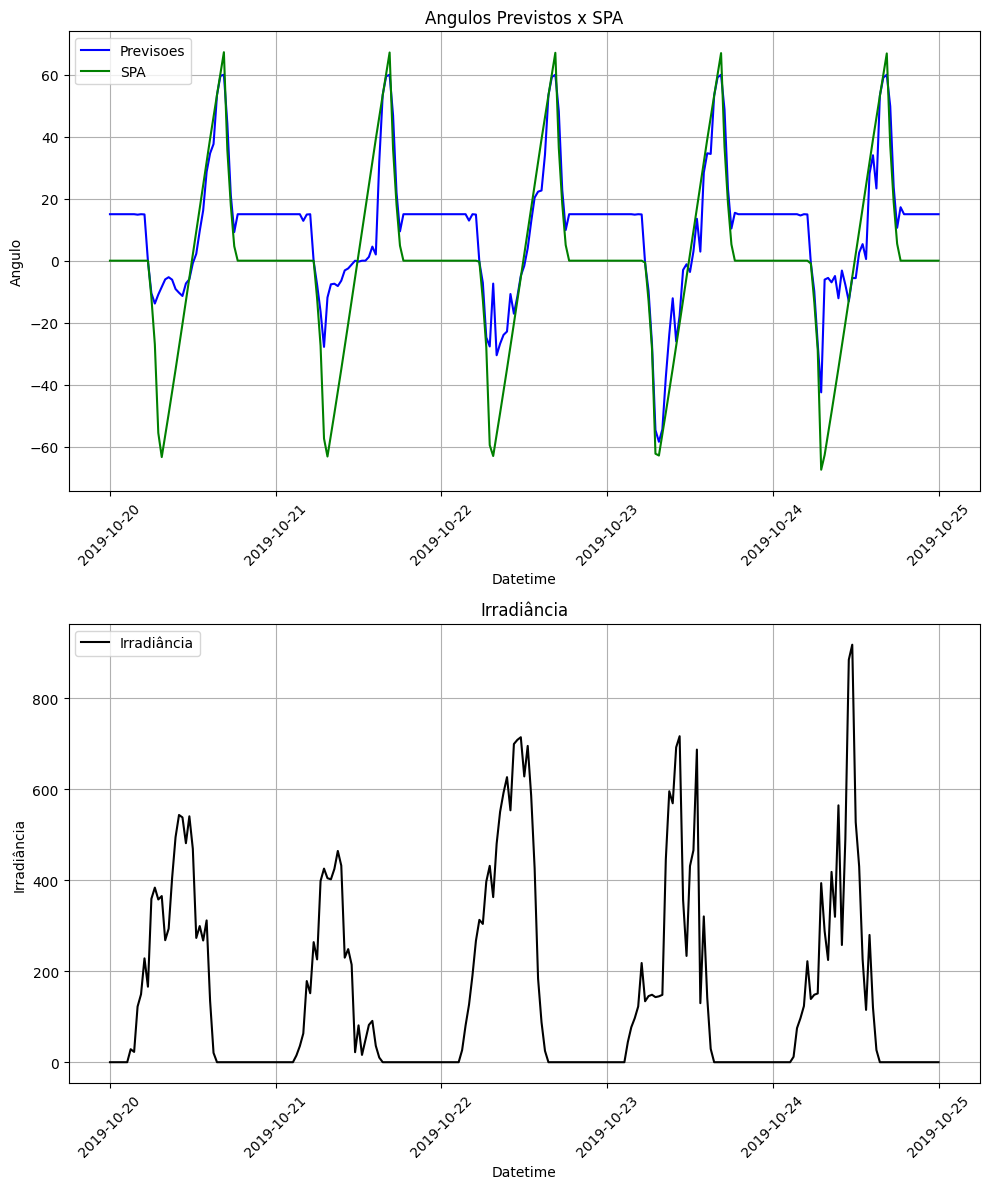

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 12)) 

dates_desejados = data['datetime_local'][6:247] 
angulos_previstos = data['Predito'][6:247] 
angulos_SPA = data['Theta'][6:247]
irradiancia_ia = data['irradiancias IA'][6:247]    
irradiancia_spa = data['irradiancias SPA'][6:247]  

# Primeiro subplot para Irradiância IA
plt.subplot(2, 1, 1)  # (número de linhas, número de colunas, índice do plot)
plt.plot(dates_desejados, angulos_previstos, label='Previsoes', color='blue')
plt.plot(dates_desejados, angulos_SPA , label='SPA', color='green')
plt.xlabel('Datetime')
plt.ylabel('Angulo')
plt.title('Angulos Previstos x SPA')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Segundo subplot para Irradiância SPA
plt.subplot(2, 1, 2)
plt.plot(dates_desejados, irradiancia_ia, label='Irradiância', color='black')
plt.xlabel('Datetime')
plt.ylabel('Irradiância')
plt.title('Irradiância')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)  # Adicionar grade ao gráfico
plt.tight_layout()

# Exibir os gráficos
plt.show()